In [1]:
#import external libraries
import pandas as pd
import datetime
import pytz
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
import scipy
#plotting
%matplotlib notebook
import seaborn as sns; sns.set(style='whitegrid')

#import self-written libraries
from settings import Glacier, Station, base_path
import plot_funcs

In [2]:
import imp

In [3]:
imp.reload(plot_funcs)

<module 'plot_funcs' from 'C:\\Users\\ehbaker\\Documents\\Python\\Modules\\plot_funcs.py'>

In [4]:
start_good_overlap_precip_date='2013-09-13'#'2013-08-28'

In [5]:
#Read in data
data_dir=base_path +"Data/"+Glacier+ r"/AllYears/Wx/LVL2/emily/"
fl=Glacier.lower()+ Station + "_daily_"+"LVL2.csv"
pth=os.path.join(data_dir, fl)
dat=pd.read_csv(pth)
print("read data from "+ pth)

#Set time index
dat.Date=pd.to_datetime(dat.Date, format='%Y/%m/%d')
dat=dat.set_index('Date')
last_stage_date=dat.Stage_Precip.last_valid_index() #get last date that old precip gage has data

read data from Q:/Project Data/GlacierData/Benchmark_Program/Data/Wolverine/AllYears/Wx/LVL2/emily/wolverine990_daily_LVL2.csv


In [6]:
dat.columns

Index(['Temp_min', 'Temp_max', 'Temp_WMO', 'Temp_USGS', 'Stage_Precip',
       'TPG_Precip', 'RelHum', 'WindSpeed', 'WindGustSpeed', 'RadiationIn',
       'RadiationOut', 'SnowDepth', 'WindDir', 'VecAvgWindDir'],
      dtype='object')

In [7]:
precip_cols=['Stage_Precip', 'TPG_Precip']
precip_dat=dat[precip_cols]
precip_related_dat=dat[['Temp_USGS','WindSpeed']]
precip_dat=precip_dat[start_good_overlap_precip_date:last_stage_date] #day after wind screen was repaired to final configuration at TPG 

In [8]:
precip_dat=precip_dat.dropna(how='all') #drop days where both are NAN

<IPython.core.display.Javascript object>


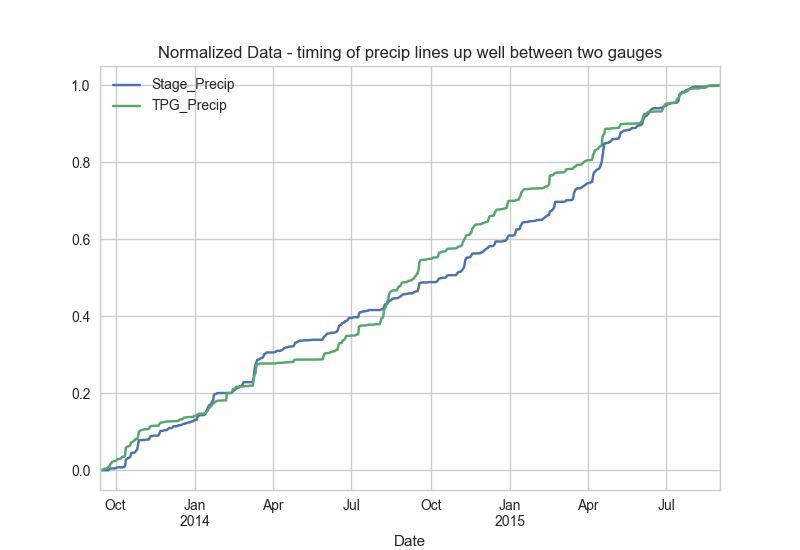

In [9]:
#Normalize data
precip_dat_norm=(precip_dat.cumsum()-precip_dat.cumsum().min())/(precip_dat.cumsum().max()-precip_dat.cumsum().min())
precip_dat_norm.plot()
plt.title("Normalized Data - timing of precip lines up well between two gauges")

<IPython.core.display.Javascript object>


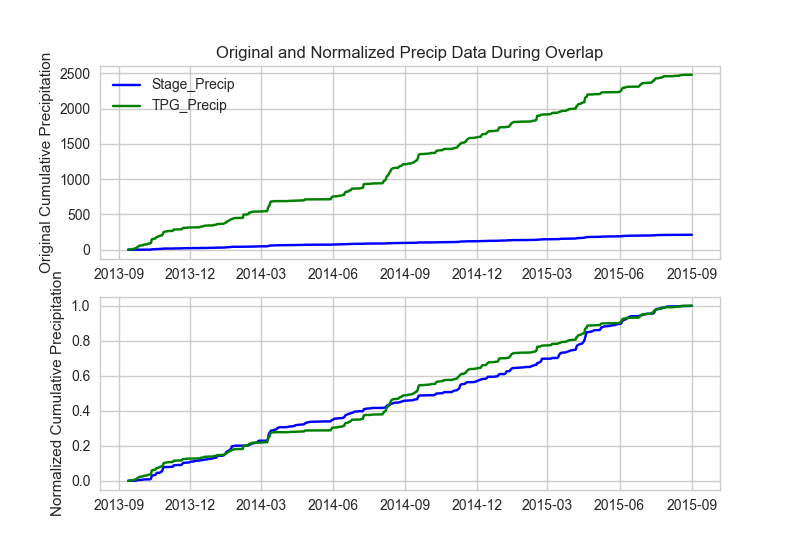

In [10]:
#Plot Cumulative Timeseries to see the problem
plt.figure()
plt.subplot(2, 1, 1)
plt.plot(precip_dat.index, precip_dat[precip_cols[0]].cumsum(),'blue')
plt.plot(precip_dat.index, precip_dat[precip_cols[1]].cumsum(), 'green')
plt.title('Original and Normalized Precip Data During Overlap')
plt.ylabel('Original Cumulative Precipitation')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(precip_dat_norm.index, precip_dat_norm[precip_cols[0]], 'blue')
plt.plot( precip_dat_norm.index, precip_dat_norm[precip_cols[1]],'green')
plt.ylabel('Normalized Cumulative Precipitation')
plt.show()

In [11]:
#Q-Q plot
# fig=plt.figure()
# ax = fig.add_subplot(111)
# res=scipy.stats.probplot(precip_dat.TPG_Precip.dropna(), dist='norm', plot=ax)

<IPython.core.display.Javascript object>


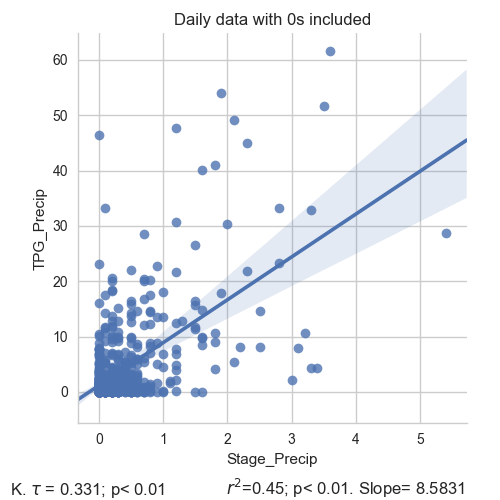

In [12]:
plot_funcs.OLS_plot(precip_cols[0], precip_cols[1], dat=precip_dat)
plt.title("Daily data with 0s included")

<IPython.core.display.Javascript object>


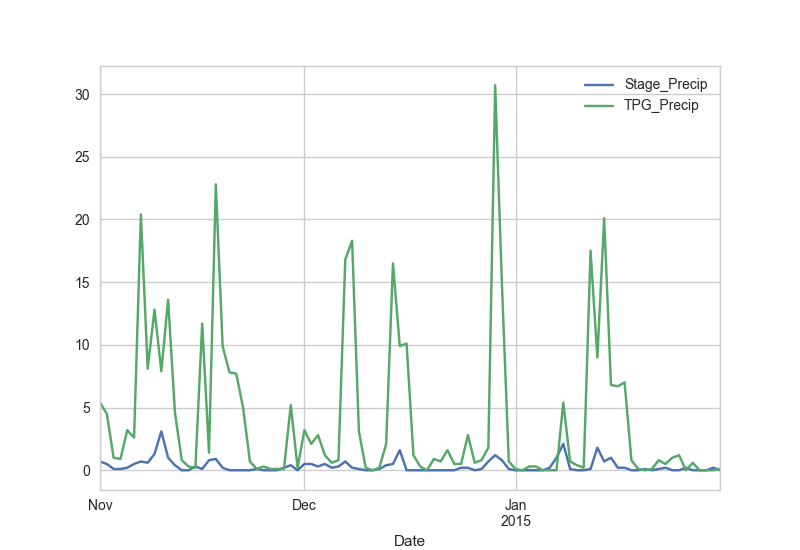

In [13]:
#Plot individual days to see how well precipitation measurements line up
precip_dat['2014-11': '2015-01'].plot()

In [14]:
#Keep no-precip days; smooth record with running mean

In [15]:
precip_dat_7=precip_dat.rolling(7).mean()

<IPython.core.display.Javascript object>


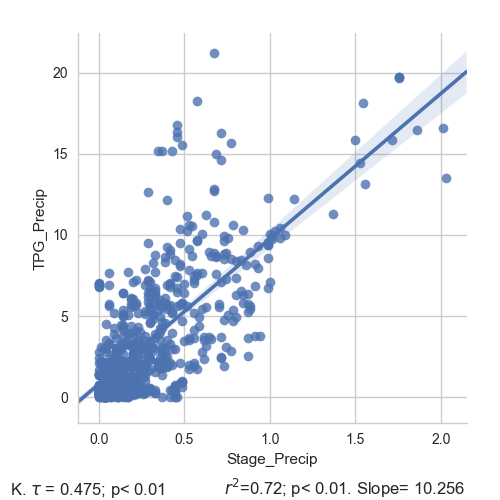

In [16]:
plot_funcs.OLS_plot(precip_cols[0], precip_cols[1], dat=precip_dat_7)

<IPython.core.display.Javascript object>


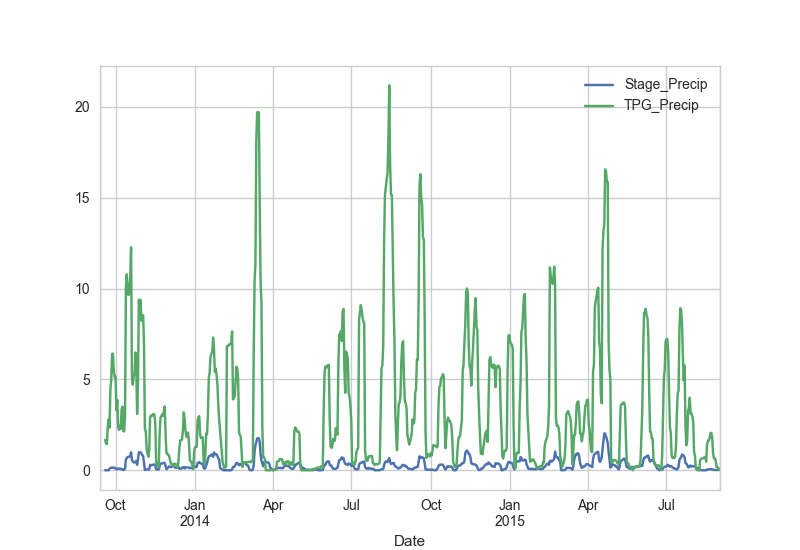

In [17]:
precip_dat_7.plot()

In [18]:
precip_dat_30=precip_dat.rolling(30).mean()

<IPython.core.display.Javascript object>


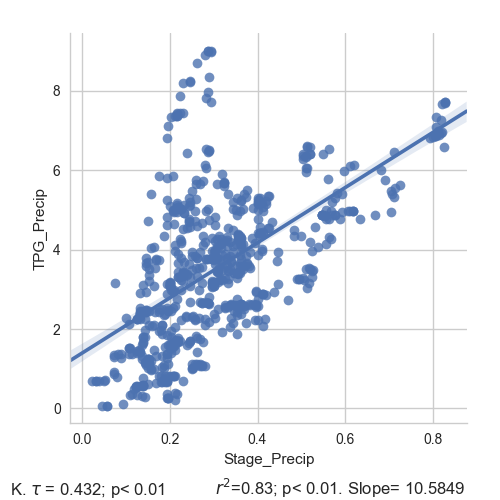

In [19]:
plot_funcs.OLS_plot(precip_cols[0], precip_cols[1], dat=precip_dat_30)

<IPython.core.display.Javascript object>


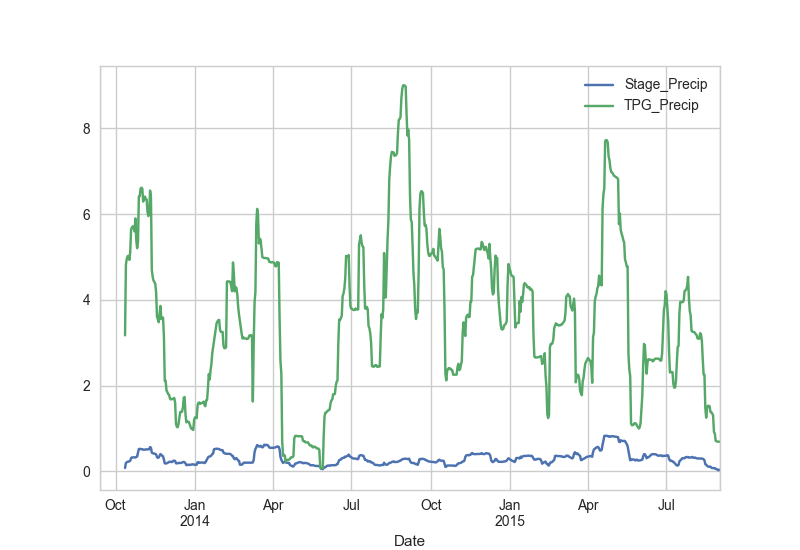

In [20]:
precip_dat_30.plot()

## Remove 0 precip days from dataset

In [21]:
#Removing 0s from the dataset
precip_dat_no0=precip_dat.copy()
for col in precip_cols:
    precip_dat_no0.loc[precip_dat[col]==0]=pd.np.nan

<IPython.core.display.Javascript object>


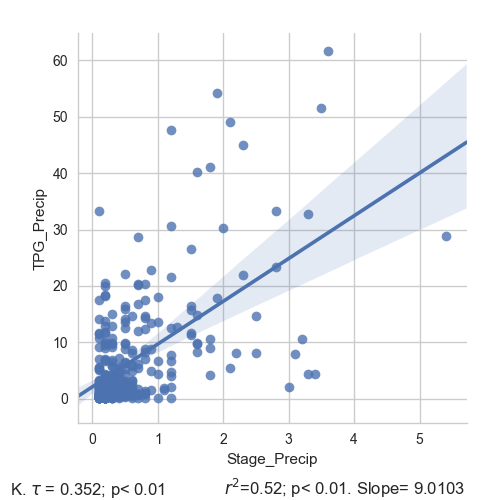

In [22]:
plot_funcs.OLS_plot(precip_cols[0], precip_cols[1], dat=precip_dat_no0)

In [23]:
#Add temperature and wind speed to data
wx_dat=precip_dat.merge(precip_related_dat, left_index=True, right_index=True, how='left')

In [24]:
#Identify cutoff values for high, medium, and low precip days
trace_stage=0.5
trace_tpg=5
high_stage=1.0
high_tpg=10

In [37]:
#Create high, medium, and low precip phase ID
wx_dat['precip_rate']=pd.np.nan
wx_dat.loc[(wx_dat.Stage_Precip<trace_stage)| (wx_dat.TPG_Precip<trace_tpg), 'precip_rate']='trace'
wx_dat.loc[(wx_dat.Stage_Precip>high_stage)| (wx_dat.TPG_Precip>high_tpg), 'precip_rate']='heavy'
wx_dat.loc[(wx_dat.Stage_Precip>trace_stage) & (wx_dat.Stage_Precip<high_stage) | (wx_dat.TPG_Precip>trace_tpg) & (wx_dat.TPG_Precip<high_tpg), 'precip_rate']='medium'

#Make Phase column for all 3
def make_phase_column(all_daily_dat, temp_col='Temp_USGS'):
    all_daily_dat['phase']=pd.np.nan
    all_daily_dat.loc[all_daily_dat[temp_col]<-1, 'phase']="snow"
    all_daily_dat.loc[all_daily_dat[temp_col]>1, 'phase']='rain'
    all_daily_dat.loc[(all_daily_dat[temp_col]>-1) & (all_daily_dat[temp_col]<=1), 'phase']='mixed'
    all_daily_dat['phase']=all_daily_dat.phase.astype('category')
    return (all_daily_dat)

all_dat=make_phase_column(wx_dat)

<IPython.core.display.Javascript object>


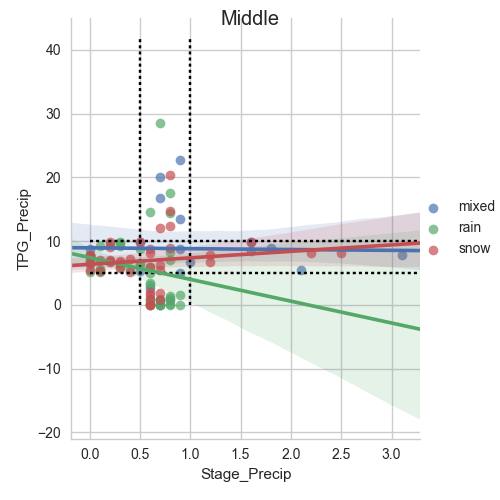

In [31]:
#Plot of Medium precip
col_y=precip_cols[1]
col_x=precip_cols[0]
g=sns.lmplot(col_x, col_y, data=mid_dat, hue='phase', scatter_kws={'alpha':0.7}, legend=False)
plt.hlines(y=trace_tpg, xmin=0, xmax=1000, linestyles='dotted')
plt.hlines(y=high_tpg, xmin=0, xmax=1000, linestyles='dotted')

plt.vlines(x=trace_stage, ymin=0, ymax=42, linestyles='dotted')
plt.vlines(x=high_stage, ymin=0, ymax=42, linestyles='dotted')
plt.suptitle("Middle")
#Add Legend to right side of figure
box = g.ax.get_position() # get position of figure
g.ax.set_position([box.x0, box.y0, box.width * 0.85, box.height]) # resize position
g.ax.legend(loc='center right', bbox_to_anchor=(1.25, 0.5), ncol=1)
sns.plt.show(g)

<IPython.core.display.Javascript object>


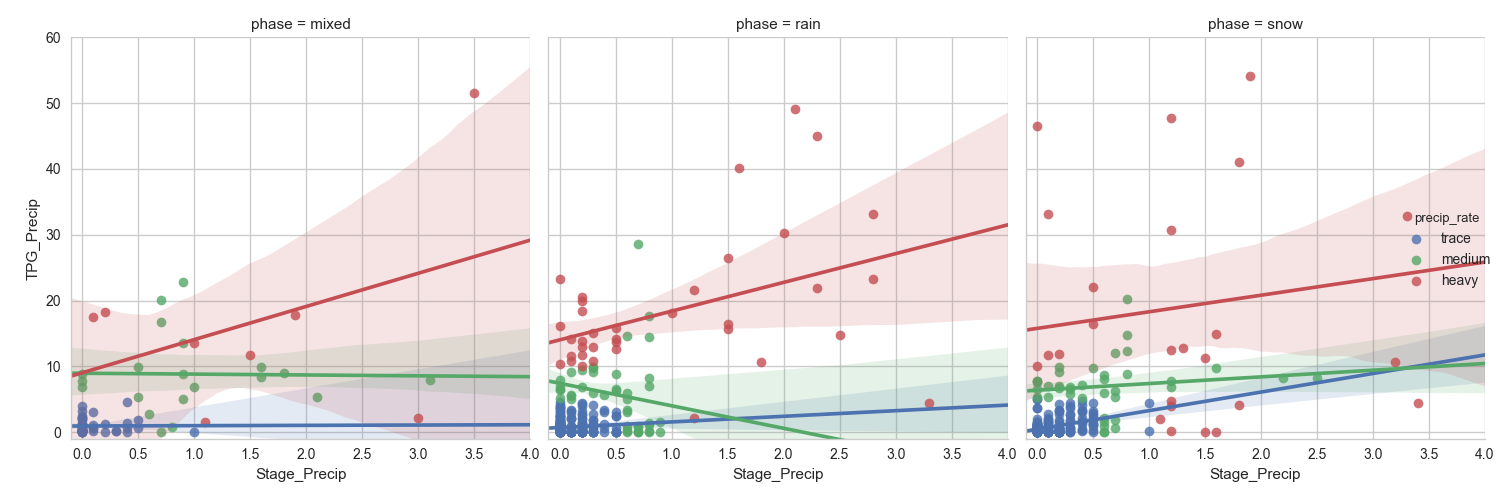

In [55]:
g=sns.lmplot(col_x, col_y, data=all_dat, hue='precip_rate', col='phase')
g=g.set(ylim=(-1, 60))
g=g.set(xlim=(-0.1,4))


<IPython.core.display.Javascript object>


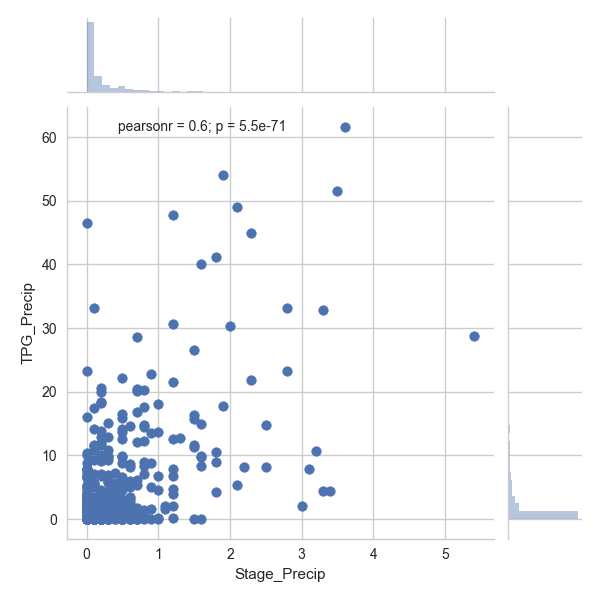

In [46]:
sns.jointplot(col_x, col_y, data=all_dat, stat_func=kend)

<IPython.core.display.Javascript object>


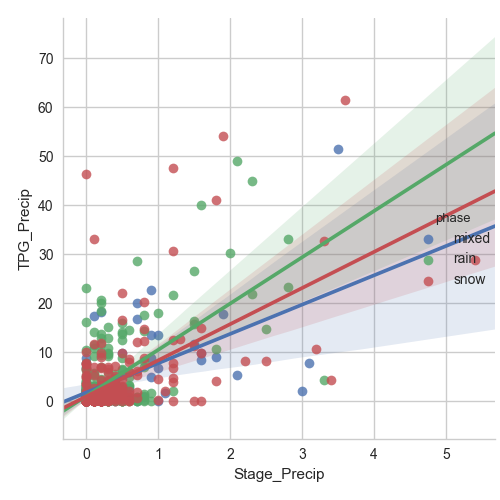

In [53]:
g=sns.lmplot(col_x, col_y, data=all_dat, hue='phase')


In [57]:
all_dat.columns

Index(['Stage_Precip', 'TPG_Precip', 'Temp_USGS', 'WindSpeed', 'phase',
       'precip_rate'],
      dtype='object')

<IPython.core.display.Javascript object>


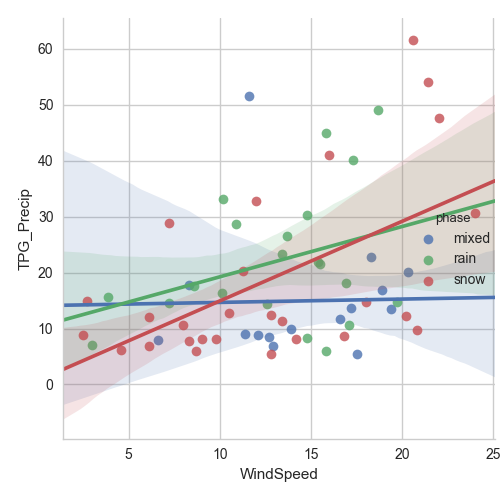

In [67]:
g=sns.lmplot('WindSpeed', col_y, data=all_dat[(all_dat.WindSpeed>1) & (all_dat.TPG_Precip>trace_tpg) 
                                              & (all_dat.Stage_Precip>trace_stage)], hue='phase')


In [ ]:
#Do cumulaive sum plots to see WHERE all the difference in the cumulative timeseries is coming from
#Is it mainly on BIG precip days? Or just the little guys, where TPG picks up a lil bit and stage misses all?
#UGHHH
#Need to phone a friend for #help
#Git Add this